In [461]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt                                                                                                                                                               

Things We should look at 
- how homogenous are today's festivals?
- what are the festivals that stand out as most unique? most median?
- what bands are the most "promiscuous" festival acts?
- are there other interesting patterns that indicate "behind the scenes" factors, such as shared booking/promoters, etc.?
- if you made a "consensus" festival for 2016, what would it look like? (would be great to design a fake poster for this)


In [464]:
df = pd.read_csv('/Users/hunterowens/Downloads/Festivals - 2016 (1).csv')

In [465]:
df.drop([0,1,2], inplace=True)
df.drop(['AVG RANK','# OF FESTS', 'PWR RANKING', 'Unnamed: 4',
        'ACL', 'EAUXCLAIRE','Unnamed: 26','BUMBERSHT']
        , axis=1, inplace=True)
df.set_index('ARTIST', inplace=True)

## Homogentity Score
- How similar to the avg festival is this festival 
- Computed Value is the Percentage of the Festival that appears in another fesitival 

In [503]:
def compute_percentage_of_lineup_in_other_festivals(lineup, df): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival """
    sum_lineup = df[lineup].count()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    fest_lineup_list = df[lineup].dropna().index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / sum_lineup
    return percentage

In [504]:
d = {}
for column in df.columns.get_values():
    d[column] = 1 - compute_percentage_of_lineup_in_other_festivals(column, df)

0    0.342105
dtype: float64


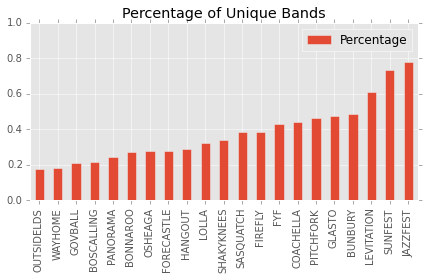

In [507]:
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
print(percentage_fest_df.median())
percentage_fest_df.columns = ['Percentage']
ax = percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
                                                     title="Percentage of Unique Bands",
                                                     ylim=(0,1))
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/percentage_unique.svg', format='svg')

## Percentage of Unique Bands in Percentiles of Lineup 

In [534]:
def compute_percentage_of_lineup_in_other_festivals_percentile(lineup, df, range_inclusive=(0,15)): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival. 
    Given a tuple range of numbers """
    # get the sum
    sum_lineup = df[lineup].count()
    s = df[lineup].dropna().astype(int)
    fest_lineup_list = s.where(s >= range_inclusive[0]).where(s <= range_inclusive[1]).dropna().index.get_values()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / len(fest_lineup_list)
    return percentage

In [535]:
d = {}
for column in df.columns.get_values():
    cuts = [int(v) for v in pd.qcut(df[column].dropna().astype(int), 4, retbins=True)[1]]
    bins = [x for x in itertools.combinations(cuts, r=2)]
    bins = [bins[0],bins[4],bins[7],bins[9]]
    d[column] = [1 - compute_percentage_of_lineup_in_other_festivals_percentile(column, df, range_inclusive=(x)) 
                 for x in bins]
                     
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
percentage_fest_df.columns = ['Top 25%','25-50%','50-75%','75-100%']
#percentage_fest_df.columns = ['Percentage']
#percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
#                                                     title="Percentage of Unique Bands Top %25 of Bill",
#                                                     ylim=(0,1))

In [536]:
percentage_fest_df.mean()

Top 25%    0.239950
25-50%     0.330356
50-75%     0.391688
75-100%    0.557257
dtype: float64

In [537]:
percentage_fest_df.median()

Top 25%    0.186047
25-50%     0.263158
50-75%     0.360000
75-100%    0.545455
dtype: float64

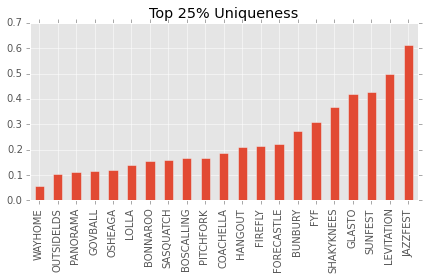

In [540]:
ax = percentage_fest_df['Top 25%'].sort_values().plot(kind='bar', title="Top 25% Uniqueness")
plt.tight_layout()
ax.get_figure().savefig(
    './festival_extras/top25percentunique.svg', format='svg')

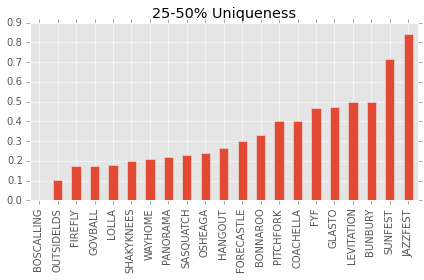

In [541]:
ax = percentage_fest_df['25-50%'].sort_values().plot(kind='bar', title="25-50% Uniqueness")
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/2550unique.svg')

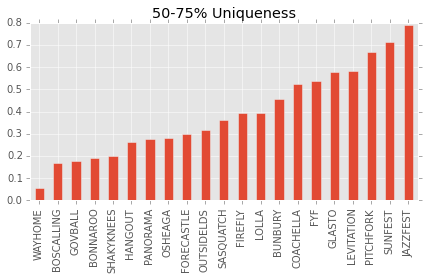

In [542]:
ax = percentage_fest_df['50-75%'].sort_values().plot(kind='bar', title="50-75% Uniqueness")
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/5075unique.svg')

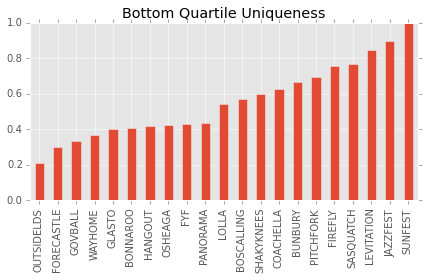

In [543]:
ax = percentage_fest_df['75-100%'].sort_values().plot(kind='bar', title="Bottom Quartile Uniqueness")
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/bottomquartile.svg')

In [516]:
percentage_fest_df

,Top 25%,25-50%,50-75%,75-100%
SHAKYKNEES,0.368421,0.200000,0.200000,0.600000
FYF,0.307692,0.466667,0.538462,0.428571
GLASTO,0.421053,0.473684,0.578947,0.400000
OSHEAGA,0.120000,0.240000,0.280000,0.423077
FIREFLY,0.214286,0.172414,0.392857,0.758621
OUTSIDELDS,0.105263,0.105263,0.315789,0.210526
FORECASTLE,0.222222,0.300000,0.300000,0.300000
BOSCALLING,0.166667,0.000000,0.166667,0.571429
GOVBALL,0.117647,0.176471,0.176471,0.333333
WAYHOME,0.055556,0.210526,0.055556,0.368421


## What about bands
- What are the top 10 most promiscious bands? 

In [517]:
df.count(axis=1).sort_values(ascending=False).head(25)

ARTIST
Vince Staples                            13
Nathaniel Rateliff & the Night Sweats    10
M83                                       9
Foals                                     9
Grimes                                    9
Kurt Vile & The Violators                 8
Oh Wonder                                 8
LCD Soundsystem                           8
Haim                                      8
Disclosure                                7
Big Grams                                 7
Marian Hill                               7
Major Lazer                               7
CHVRCHES                                  6
Miike Snow                                6
Silversun Pickups                         6
Sufjan Stevens                            6
Lany                                      6
Børns                                     6
Savages                                   6
The Last Shadow Puppets                   6
Unknown Mortal Orchestra                  6
Elle King                

In [518]:
df.columns

Index(['COACHELLA', 'GOVBALL', 'BONNAROO', 'JAZZFEST', 'SUNFEST', 'LEVITATION',
       'SHAKYKNEES', 'HANGOUT', 'BOSCALLING', 'SASQUATCH', 'BUNBURY',
       'FIREFLY', 'GLASTO', 'FORECASTLE', 'PITCHFORK', 'PANORAMA', 'WAYHOME',
       'LOLLA', 'OSHEAGA', 'OUTSIDELDS', 'FYF'],
      dtype='object')

## Power Rankings
* We calculate a power rank based on three factors. 
* Each act gets a score from 1-100 for a festival appearance, which is essentially percentile rank within fest. 
* Then, each festival is given a coefficient from 0-1 based on size. 

Then sum and multiply. 



In [519]:
fest_co = [i + 0.04761905 for i in np.arange(0,1, (1 / df.count().sort_values().count()))]

In [520]:
festival_co = {}
for fest in enumerate(df.count().sort_values().iteritems()):
    fest_name = fest[1][0]
    pfest_co = fest_co[fest[0]]
    festival_co[fest_name] = pfest_co

In [521]:
def calculate_power_rank(artist):
    """Calculates the power rankings"""
    artist_series = df.ix[artist]
    power_rank = 0
    for fest_tuple in artist_series.iteritems():        
        if not pd.isnull(fest_tuple[1]): 
            fest_count = df[fest_tuple[0]].count()
            artist_rank = fest_tuple[1]
            percentile = 1 - (float(artist_rank) / float(fest_count))
            power_rank += percentile * 100 * festival_co[fest_tuple[0]]
    return power_rank

In [522]:
power_ranks = {}
for artist in df.index:
    power_ranks[artist] = calculate_power_rank(artist)
power_rank_df = pd.DataFrame.from_dict(power_ranks, orient='index')
power_rank_df = power_rank_df.rename(columns={0: "powerRank"})

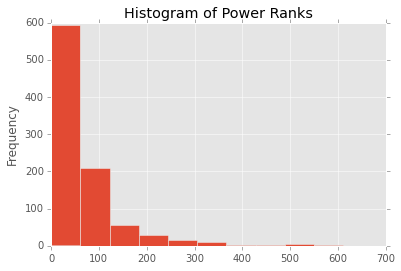

In [547]:
ax = power_rank_df['powerRank'].sort_values().plot(kind='hist', title=
                                              "Histogram of Power Ranks")
ax.get_figure().savefig('./festival_extras/histpowerrank.svg')

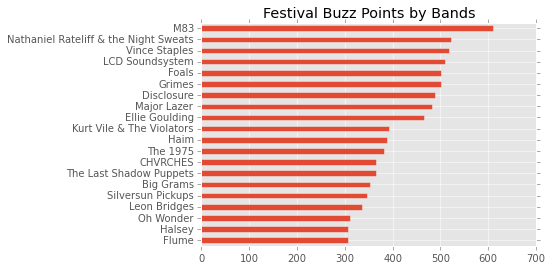

In [581]:
# Top 10
ax = power_rank_df['powerRank'].sort_values().tail(20).plot(kind="barh", title=
                                                                      "Festival Buzz Points by Bands")
ax.get_figure().savefig('./festival_extras/festpowerbyband.svg', bbox_inches='tight')

## Festivals WAR over Bands 
* This is each festivals WAR divided by the number of bands in the fest  - basically avg rank

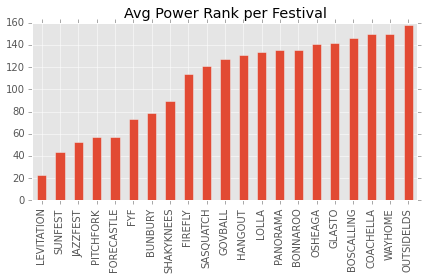

In [567]:
festival_rank = {} 
for festival in df.iteritems():
    fest = festival[0]
    sum_ranks = 0
    for artist in df[fest].dropna().iteritems():
        sum_ranks += power_rank_df.ix[artist[0]][0]
    festival_rank[fest] = (sum_ranks, sum_ranks / df[fest].count())
ax = pd.DataFrame.from_dict(festival_rank, orient='index')[1].sort_values().plot(kind="bar", 
                                                                            title="Avg Buzz Rank per Festival")
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/powerrankbyfest.svg', bbox_inches='tight')

In [526]:
df.ix[['M83','LCD Soundsystem']].transpose().count()

ARTIST
M83                9
LCD Soundsystem    8
dtype: int64

# CloutScore
PowerRank / Number of Fests. 

In [527]:
power_rank_df['cloutscore'] = power_rank_df['powerRank'] / df.transpose().count()
power_rank_df['count'] = df.transpose().count()

In [528]:
power_rank_df.sort_values('cloutscore', ascending=False).head(20)

,powerRank,cloutscore,count
Guns N Roses,94.646555,94.646555,1
Jack Ü,92.871932,92.871932,1
Rancid,91.097309,91.097309,1
James Bay,90.505768,90.505768,1
Mumford & Sons,89.661090,89.661090,1
Edward Sharpe and the Magnetic Zeros,89.322686,89.322686,1
Kings of Leon,88.845989,88.845989,1
Hardwell,88.304094,88.304094,1
Martin Garrix,87.719298,87.719298,1
Volbeat,87.548063,87.548063,1


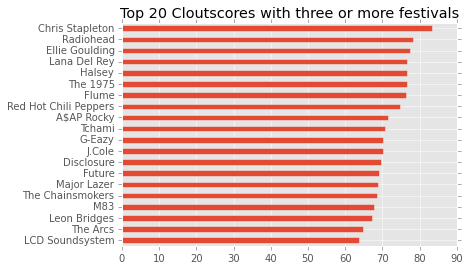

In [582]:
ax = power_rank_df[power_rank_df['count'] > 2]['cloutscore'].sort_values().tail(20).plot(kind='barh',
                                                        title="Top 20 Cloutscores with three or more festivals")

ax.get_figure().savefig('./festival_extras/top20clout.svg', bbox_inches='tight') 

In [569]:
clout_s = pd.Series()
for fest in df.columns:
    artists_in_fest = df[fest].dropna().index
    sum_fest_clouts = 0
    for artist in artists_in_fest:
        sum_fest_clouts += power_rank_df['cloutscore'][artist]
    clout_s[fest] = sum_fest_clouts / len(artists_in_fest)

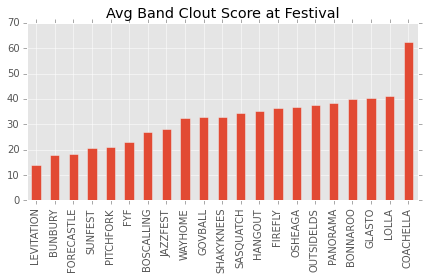

In [570]:
ax = clout_s.sort_values().plot(kind='bar',
                          title='Avg Band Clout Score at Festival')
plt.tight_layout()
ax.get_figure().savefig('./festival_extras/avgbandclout.svg')

In [532]:
power_rank_df.sort_values('powerRank', ascending=False)

,powerRank,cloutscore,count
M83,610.493180,67.832576,9
Nathaniel Rateliff & the Night Sweats,523.049647,52.304965,10
Vince Staples,518.222728,39.863287,13
LCD Soundsystem,509.109312,63.638664,8
Foals,501.956273,55.772919,9
Grimes,501.788876,55.754320,9
Disclosure,488.189026,69.741289,7
Major Lazer,481.774623,68.824946,7
Ellie Goulding,465.198549,77.533091,6
Kurt Vile & The Violators,391.436072,48.929509,8
